<a href="https://colab.research.google.com/github/SkovenForrest/Cellari_project/blob/master/Cellari_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cellario U-Net

#Load data 

In [31]:
import torch
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import DataLoader, Dataset
import glob
import natsort
from PIL import Image
import matplotlib.pyplot as plt
import cv2


In [32]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:

#!ls drive/'My Drive'
!ls drive/'My Drive/Gland_dataset' &> /dev/null

images_path = 'drive/My Drive/Cellari_project/Gland_dataset/*'


In [40]:


images = []
masks = []

# image preperation
train_images = glob.glob(images_path)
sorted_train_images = natsort.natsorted(train_images, reverse=False)


In [41]:
for img in train_images:
    name_img = img.split("/")[-1].split(".")[0]
    imagg = name_img.split("_")[-1]
    if imagg == "anno":
        masks.append(img)
    else:
        images.append(img)

print(len(images))
print(len(masks))
#print(imagg)
print(images[:10])
print(masks[:10])

165
165
['drive/My Drive/Cellari_project/Gland_dataset/train_32.bmp', 'drive/My Drive/Cellari_project/Gland_dataset/train_65.bmp', 'drive/My Drive/Cellari_project/Gland_dataset/train_64.bmp', 'drive/My Drive/Cellari_project/Gland_dataset/train_38.bmp', 'drive/My Drive/Cellari_project/Gland_dataset/train_55.bmp', 'drive/My Drive/Cellari_project/Gland_dataset/train_6.bmp', 'drive/My Drive/Cellari_project/Gland_dataset/train_4.bmp', 'drive/My Drive/Cellari_project/Gland_dataset/train_52.bmp', 'drive/My Drive/Cellari_project/Gland_dataset/train_67.bmp', 'drive/My Drive/Cellari_project/Gland_dataset/train_80.bmp']
['drive/My Drive/Cellari_project/Gland_dataset/testB_1_anno.bmp', 'drive/My Drive/Cellari_project/Gland_dataset/testB_16_anno.bmp', 'drive/My Drive/Cellari_project/Gland_dataset/testB_17_anno.bmp', 'drive/My Drive/Cellari_project/Gland_dataset/testB_14_anno.bmp', 'drive/My Drive/Cellari_project/Gland_dataset/testB_13_anno.bmp', 'drive/My Drive/Cellari_project/Gland_dataset/testB_1

In [42]:
train_orig_images = []
train_masks = []

test_orig_images = []
test_masks = []

In [43]:
for img in images:
    name_img = img.split("/")[-1].split(".")[0]
    imagg = name_img.split("_")[0]
    if imagg == "testA" or imagg == "testB":
        test_orig_images.append(img)
    else:
        train_orig_images.append(img)

for mask in masks:
    mask_img = mask.split("/")[-1].split(".")[0]
    imagg = mask_img.split("_")[0]
    if imagg == "testA" or imagg == "testB":
        test_masks.append(mask)
    else:
        train_masks.append(mask)


In [44]:
print(len(train_orig_images), len(train_masks))
print(len(test_orig_images), len(test_masks))

85 85
80 80


In [45]:
sorted_train_images = natsort.natsorted(train_orig_images, reverse=False)
sorted_train_masks = natsort.natsorted(train_masks, reverse=False)

sorted_test_images = natsort.natsorted(test_orig_images, reverse=False)
sorted_test_masks = natsort.natsorted(test_masks, reverse=False)

In [46]:
#mean = (0.485, 0.456, 0.406)
#std = (0.229, 0.224, 0.225)
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])

transformations = transforms.Compose([transforms.Resize((512,512)) , transforms.ToTensor() , transforms.Normalize(mean, std)])


In [47]:
# Data transformations

class CellarDataset(Dataset):
    def __init__(self, images, masks, transforms):
        super(CellarDataset, self).__init__()
        self.images = images
        self.masks = masks
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, item):
        orig_image = cv2.imread(self.images[item])
        orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
        orig_image = Image.fromarray(orig_image)

        mask_image = cv2.imread(self.masks[item])
        mask_image = cv2.cvtColor(mask_image, cv2.COLOR_BGR2RGB)
        mask_image = Image.fromarray(mask_image)

    
        trans_img = self.transforms(orig_image)
        trans_mask = self.transforms(mask_image)


        return trans_img, trans_mask

In [48]:
# Data Loader
batch_size = 32 

train_dataset = CellarDataset(sorted_train_images,sorted_train_masks, transformations)
test_dataset = CellarDataset(sorted_test_images,sorted_test_masks, transformations)

train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



In [49]:
#visualising the images 
def imshow_images(dataloader, bs=2):
  fig = plt.figure(figsize=(24, 16))
  fig.tight_layout()
  images , masks = next(iter(dataloader))

  for num, (image, mask) in enumerate(zip(images[:bs], masks[:bs])):
      plt.subplot(4,6,num+1)
      plt.axis('off')
      image = image.cpu().numpy()
      out = np.transpose(image, (1,2,0))
      #mean = np.array([0.485, 0.456, 0.406])
      #std = np.array([0.229, 0.224, 0.225])

      mean = np.array([0.5, 0.5, 0.5])
      std = np.array([0.5, 0.5, 0.5])
      #print(mean)
      inp = std * out + mean
      inp = np.clip(inp, 0, 1)
      plt.imshow(inp)


#visualising the images 
def imshow_masks(dataloader, bs=2):
  fig = plt.figure(figsize=(24, 16))
  fig.tight_layout()
  images , masks = next(iter(dataloader))

  for num, (image, mask) in enumerate(zip(images[:bs], masks[:bs])):
      plt.subplot(4,6,num+1)
      plt.axis('off')
      mask = mask.cpu().numpy()
      out = np.transpose(mask, (1,2,0))

      #mean = np.array([0.485, 0.456, 0.406])
      #std = np.array([0.229, 0.224, 0.225])

      mean = np.array([0.5, 0.5, 0.5])
      std = np.array([0.5, 0.5, 0.5])

      inp = std * out + mean
      inp = np.clip(inp, 0, 1)
      plt.imshow(inp)

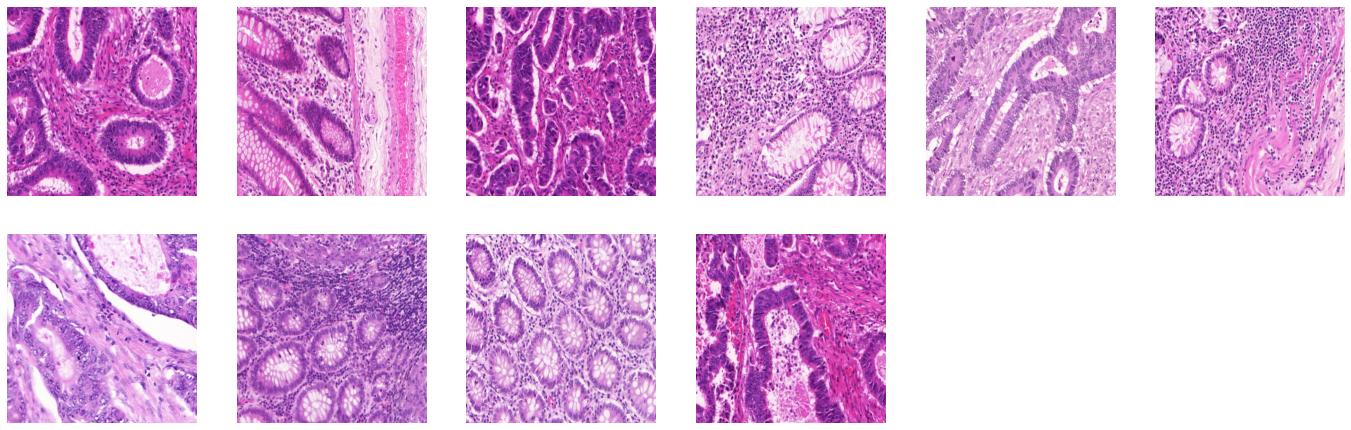

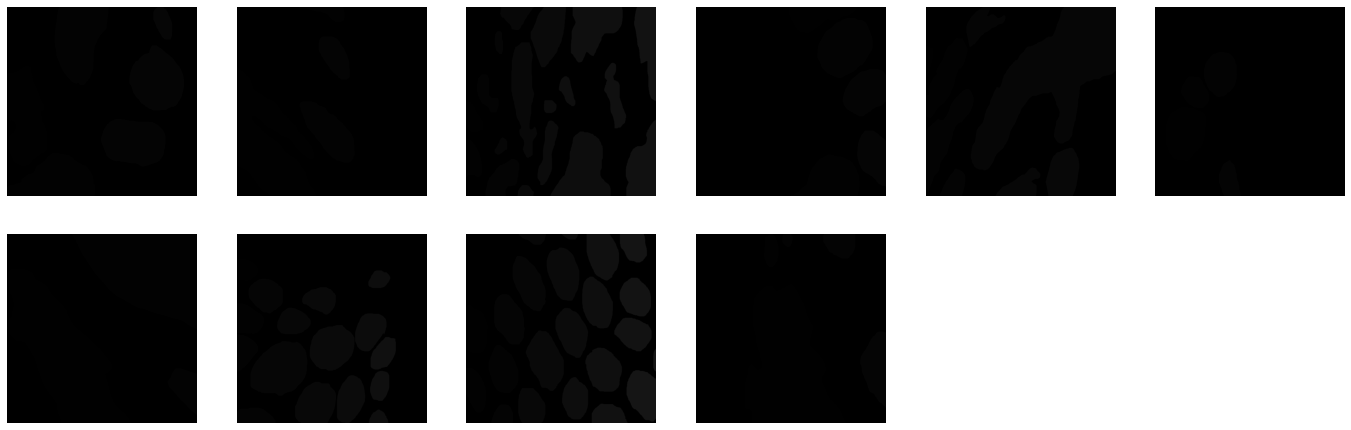

In [50]:
imshow_images(train_loader, bs=10)
imshow_masks(train_loader, bs=10)

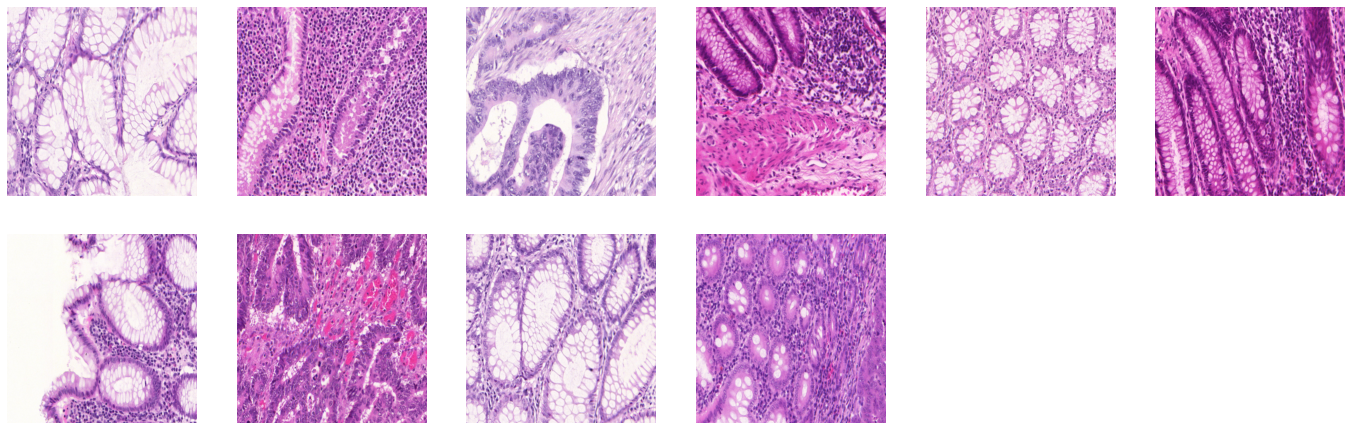

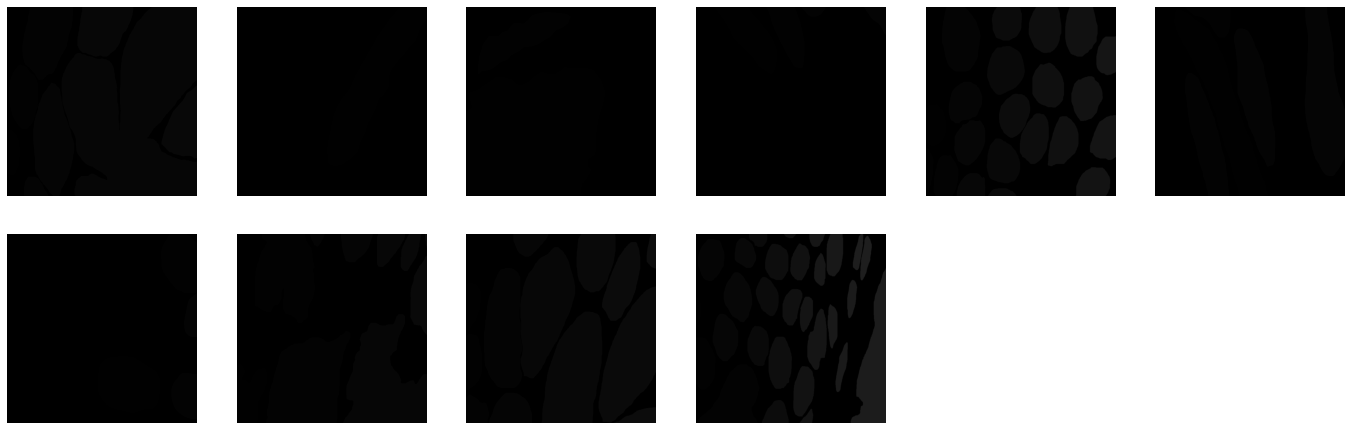

In [51]:
imshow_images(test_loader, bs=10)
imshow_masks(test_loader, bs=10)

# Build the model

The U-Net architecture


In [52]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Linear, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, sigmoid, tanh, softmax

In [53]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


In [54]:

def double_conv(channel_in, channel_out):
  conv = nn.Sequential(
      nn.Conv2d(channel_in, channel_out, kernel_size = 3, stride = 1, padding = 1),
      nn.ReLU(inplace=True),
      nn.Conv2d(channel_out, channel_out, kernel_size = 3, stride = 1, padding = 1),
      nn.ReLU(inplace=True)
  )
  return conv

def image_cropping(x1, x2):
  train_images_cropped = F.interpolate(x1, size= x2.size()[2])
  return train_images_cropped


class U_Net(nn.Module):
    def __init__(self):
        super(U_Net, self).__init__()
 
        self.max_pool = nn.MaxPool2d(kernel_size = 2, stride = 2)

        #convolute the image down 
        self.conv_down_1 = double_conv(3, 64)
        self.conv_down_2 = double_conv(64, 128)
        self.conv_down_3 = double_conv(128, 256)
        self.conv_down_4 = double_conv(256, 512)
        self.conv_down_5 = double_conv(512, 1024)

        #convolute the image up
        self.trans_up_1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size = 2, stride = 2)
        self.conv_up_1 = double_conv(1024, 512)

        self.trans_up_2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 2, stride = 2)
        self.conv_up_2 = double_conv(512, 256)

        self.trans_up_3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 2, stride = 2)
        self.conv_up_3 = double_conv(256, 128)

        self.trans_up_4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2, stride = 2)
        self.conv_up_4 = double_conv(128, 64)

        self.out = nn.Conv2d(in_channels = 64, out_channels = 2, kernel_size= 1)


    def forward(self, img):
        x1 = self.conv_down_1(img)
        x2 = self.max_pool(x1)
        x3 = self.conv_down_2(x2)
        x4 = self.max_pool(x3)
        x5 = self.conv_down_3(x4)
        x6 = self.max_pool(x5)
        x7 = self.conv_down_4(x6)
        x8 = self.max_pool(x7)
        x9 = self.conv_down_5(x8)


        x10 = self.trans_up_1(x9)
        crop1 = image_cropping(x7,x10)
        x11 = self.conv_up_1(torch.cat([x10,crop1],1))

        x12 = self.trans_up_2(x11)
        crop2 = image_cropping(x5,x12)
        x13 = self.conv_up_2(torch.cat([x12,crop2],1)) 

        x14 = self.trans_up_3(x13)
        crop3 = image_cropping(x3,x14)
        x15 = self.conv_up_3(torch.cat([x14,crop3],1)) 

        x16 = self.trans_up_4(x15)
        crop4 = image_cropping(x1,x16)
        x17 = self.conv_up_4(torch.cat([x16,crop4],1)) 
        output = self.out(x17)
        return output
  
  
net = U_Net()
net = net.cuda()
#print(net)
print("done")

done


#Test on dummy data 

In [55]:

# dummy data
rand_img = torch.rand((1,3,512,512))
rand_img = rand_img.cuda()

# test the forward pass
net = U_Net()
net = net.cuda()
result = net(img = rand_img)
print (result)

tensor([[[[-0.0558, -0.0517, -0.0543,  ..., -0.0530, -0.0514, -0.0530],
          [-0.0554, -0.0581, -0.0573,  ..., -0.0500, -0.0539, -0.0505],
          [-0.0581, -0.0495, -0.0511,  ..., -0.0496, -0.0489, -0.0502],
          ...,
          [-0.0548, -0.0519, -0.0507,  ..., -0.0471, -0.0488, -0.0509],
          [-0.0528, -0.0568, -0.0501,  ..., -0.0477, -0.0490, -0.0526],
          [-0.0531, -0.0524, -0.0515,  ..., -0.0498, -0.0506, -0.0523]],

         [[-0.0128, -0.0049, -0.0049,  ..., -0.0023, -0.0048, -0.0083],
          [-0.0118, -0.0017,  0.0025,  ..., -0.0092, -0.0054, -0.0134],
          [-0.0073, -0.0016, -0.0027,  ..., -0.0036, -0.0111, -0.0144],
          ...,
          [-0.0090, -0.0004, -0.0024,  ..., -0.0033, -0.0096, -0.0161],
          [-0.0106, -0.0063, -0.0079,  ..., -0.0127, -0.0113, -0.0162],
          [-0.0085, -0.0122, -0.0128,  ..., -0.0155, -0.0176, -0.0182]]]],
       device='cuda:0', grad_fn=<AddBackward0>)


#Define a Loss function and optimizer

In [26]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.99)

#Train the network

In [28]:
num_epoch = 5  # Your code here!
net.train()

for epoch in range(num_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

        # zero the parameter gradients
        # Your code here!
        optimizer.zero_grad()

        # forward + backward + optimize
        # Your code here!
        outputs = net(inputs)
        #print(outputs.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()#data[0]
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

RuntimeError: ignored